In [262]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2 as cv

baseDir = "C:/Users/Roman/Dropbox/hda/ComputerVision/Uebungen 2/"
plotDir = baseDir + "plots/"

In [151]:
# load test image

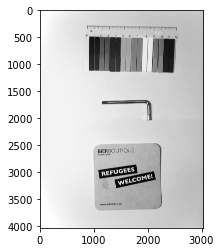

In [263]:
# Load a color image in grayscale
img = cv.imread(baseDir + 'pics/comp2.JPG')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

f = plt.imshow(img, cmap = "gray") # ,plt.title("original image"), #plt.xticks([]), plt.yticks([]), plt.show()
plt.savefig(plotDir + "input.png")
#f = plt.imshow(img, cmap = 'gray') # ,plt.title("original image"), #plt.xticks([]), plt.yticks([]), plt.show()
#plt.savefig(baseDir + "plots/fig1_all.png")

In [264]:
img.shape

(4032, 3024)

## split the image into reference object and probe object

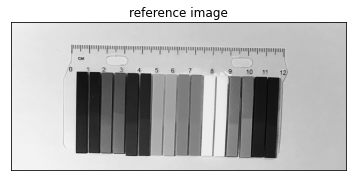

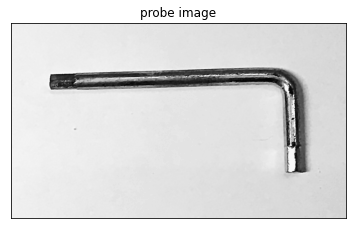

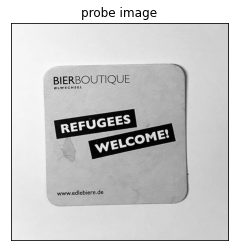

In [265]:
imgRef     = img[100:1250,400:3000].copy()
imgProbe   = img[1500:2200,1000:2200].copy()
imgProbe2  = img[2100:4000,700:2600].copy()

f = plt.imshow(imgRef, cmap = 'gray'),plt.title("reference image"), plt.xticks([]), plt.yticks([]), plt.show()
f = plt.imshow(imgProbe, cmap = 'gray'),plt.title("probe image"), plt.xticks([]), plt.yticks([]), plt.show()
f = plt.imshow(imgProbe2, cmap = 'gray'),plt.title("probe image"), plt.xticks([]), plt.yticks([]), plt.show()

# class to process images

In [266]:
import argparse
import glob

class cvProc:
    def __init__(self, image):
        self.image    = image
        self.original = image
        self.colored  = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
        self.entireImageArea = self.image.shape[0]*self.image.shape[1] # if the area is close to the image shape, then dismiss it and use the next smaller area
        self.steps    = ""
        self.plot()
    def gauss(self, FWHM = 9):
        self.image = cv.GaussianBlur(self.image, (FWHM, FWHM), 0)
        self.steps = self.steps + ">gaussian"
        self.plot()
    def median(self, size = 5):
        self.image = cv.medianBlur(self.image, size)
        self.steps = self.steps + ">median"
        self.plot()
    def binarize(self, threshold = 150):
        self.image[self.image <  threshold] = 0
        self.image[self.image >= threshold] = 255
        self.steps = self.steps + ">binarization"
        self.plot()
    def findContours(self, forceHorizontal = True):
        self.contours, self.hierarchy = cv.findContours(self.image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        self.areas = [cv.contourArea(c) for c in self.contours] # area of contour#
        while True: # look for largest contour (all but the image itself)
            maxInd = self.areas.index(np.max(self.areas)) # index of the biggest contour
            print(areas[maxInd])
            if ( self.entireImageArea - self.areas[maxInd] ) < ( self.entireImageArea * 0.1 ):
                print("dropping biggest shape")
                self.areas.pop(maxInd)
                self.contours.pop(maxInd)
            else:
                break
        c = contours[maxInd]
        if forceHorizontal:
            x, y, w, h = cv.boundingRect(c) # get the bounding rectangle
            cv.rectangle(self.colored, (x, y), (x+w, y+h), (0, 0, 255), 10) # draw a green rectangle to visualize the bounding rectangle
        else: # find the rect. with minimized area, therefore allow rotation
            rect = cv.minAreaRect(c) # get the min area rect
            box = cv.boxPoints(rect)
            box = np.int0(box) # convert all coordinates floating point values to int
            cv.drawContours(self.colored, [box], 0, (0, 0, 255), 10) # draw a red 'nghien' rectangle
        self.plot(which="lines")
    def auto_canny(self, sigma=0.33):
        v = np.median(self.image) # compute the median of the single channel pixel intensities
        lower = int(max(0, (1.0 - sigma) * v)) # apply automatic Canny edge detection using the computed median
        upper = int(min(255, (1.0 + sigma) * v))
        self.image = cv.Canny(self.image, lower, upper)
        self.steps = self.steps + ">auto-canny"
        self.plot()
    def dilero(self):
        self.image = cv.dilate(self.image, None, iterations=1)
        self.image = cv.erode(self.image, None, iterations=1)
        self.steps = self.steps + ">dilate>erode"
        self.plot()
    def houghlines(self, minline = 700, maxgap = 25, theta = np.pi/180):
        self.lines = cv.HoughLinesP(self.image,  1, theta, 20, maxLineGap=maxgap, minLineLength = minline) # threshold (last parameter) may be evaluated
        print("extracted " + str(len(self.lines)) + " lines!")
        self.lineSizes = []        
        if self.lines is not None:
            for line in self.lines:
                x1, y1, x2, y2 = line[0]
                self.lineSizes.append(np.sqrt((x2-x1)**2 + (y2-y1)**2)) # write the line distances in px
                cv.line(self.colored, (x1, y1), (x2, y2), color = (255,0,0), thickness = 10)
        self.steps = self.steps + ">houghlinesp"
        self.plot(which="lines")
    def plot(self, which = "image"):
        if which == "image": f = plt.imshow(self.image, cmap = 'gray'),plt.title(self.steps), plt.xticks([]), plt.yticks([]), plt.show()
        if which == "lines": f = plt.imshow(self.colored, cmap = 'gray'),plt.title(self.steps), plt.xticks([]), plt.yticks([]), plt.show()
    def plotlens(self):
        f = sns.swarmplot(self.lineSizes, orient="vertical")
        plt.ylabel("length | px")
        plt.title("lengths of extracted edges")
    def measure(self, refLineMM = 120):
        # externally measure the reference line
        self.mm_per_px = refLineMM / np.max(self.lineSizes)
        print("Longest line in image is " + str(np.max(self.lineSizes)) + " px.")
        print("Each pixel is around " + str(np.round(self.mm_per_px,2)) + " mm.")
    def mm_to_px(self, inpList):
        """
        takes a list of pixel distances as input, outputs distances in mm
        """
        out = [i*self.mm_per_px for i in inpList]
        return out

## reference image

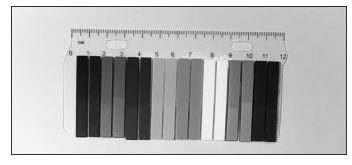

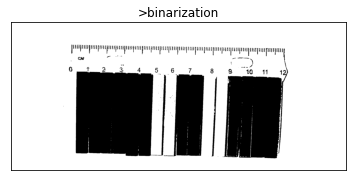

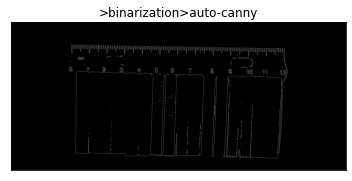

extracted 24 lines!


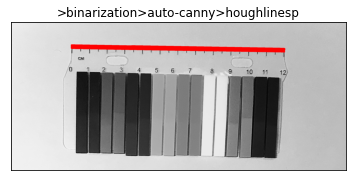

Longest line in image is 1655.2540590495466 px.
Each pixel is around 0.07 mm.


In [156]:
im = cvProc(imgRef.copy())
im.binarize(threshold=160)
im.auto_canny()
im.houghlines(minline = 700, maxgap = 30)
im.measure()

In [157]:
np.max(im.lineSizes)

1655.2540590495466

## probe image 1

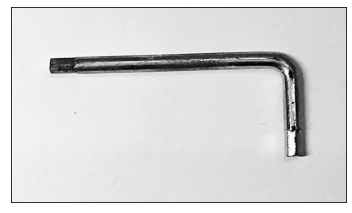

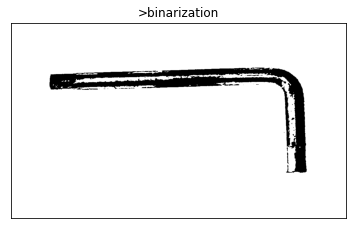

2.0
dropping biggest shape
58016.5


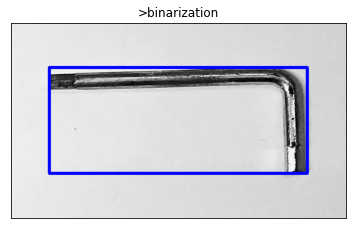

In [274]:
pr1 = cvProc(imgProbe.copy());
pr1.binarize(threshold = 120)
#pr1.auto_canny()
#pr1.houghlines(minline = 800, maxgap = 250)
pr1.findContours(forceHorizontal = True)
#im.mm_to_px(pr1.lineSizes)

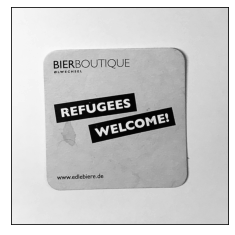

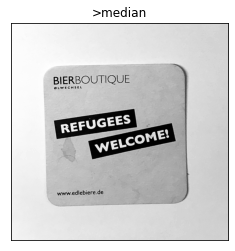

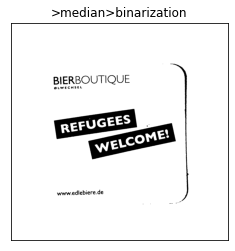

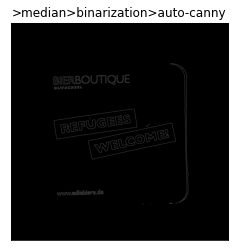

extracted 1 lines!


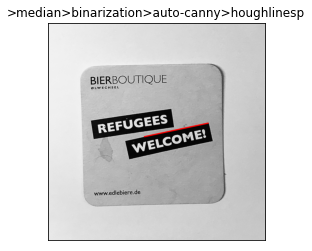

[41.205783737725696]

In [304]:
pr2 = cvProc(imgProbe2.copy())
pr2.median(size = 5)
pr2.binarize(threshold = 120)
pr2.auto_canny()
pr2.houghlines(minline = 550, maxgap = 25)

im.mm_to_px(pr2.lineSizes)

## bounding box

In [246]:
# folgendes von: https://gist.github.com/bigsnarfdude/d811e31ee17495f82f10db12651ae82d
img = pr1.image.copy()
#img = imgProbe.copy()

In [247]:
contours, hier = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [248]:
# area of contour
areas = [cv.contourArea(c) for c in contours]
# if the area is close to the image shape, then dismiss it and use the next smaller area
entireImageArea = img.shape[0]*img.shape[1]

while True:
    maxInd = areas.index(np.max(areas)) # index of the biggest contour
    print(areas[maxInd])
    if ( entireImageArea - areas[maxInd] ) < ( entireImageArea * 0.1 ):
        print("dropping biggest shape")
        areas.pop(maxInd)
        contours.pop(maxInd)
    else:
        break

838101.0
dropping biggest shape
58016.5


In [249]:
areas[maxInd]

58016.5

In [258]:
c = contours[maxInd]
# get the bounding rect
x, y, w, h = cv.boundingRect(c)
# draw a green rectangle to visualize the bounding rect
cv.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 10)

# get the min area rect
rect = cv.minAreaRect(c)
#print(rect)
box = cv.boxPoints(rect)
# convert all coordinates floating point values to int
box = np.int0(box)
# draw a red 'nghien' rectangle
cv.drawContours(img, [box], 0, (0, 0, 255), 10)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

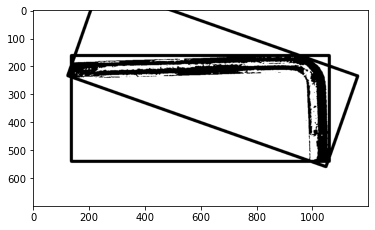

In [259]:
plt.imshow(img, cmap= "gray")

In [252]:
rect

((644.0800170898438, 234.73553466796875),
 (344.4786376953125, 980.8011474609375),
 -70.61325073242188)

In [255]:
w

924

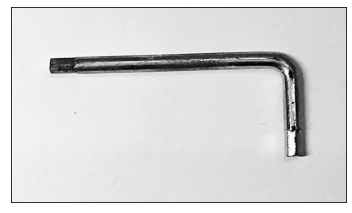

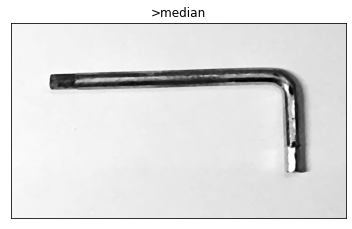

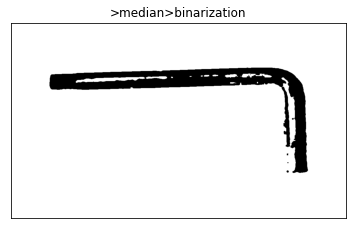

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\convhull.cpp:137: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::convexHull'


In [159]:
pr1 = cvProc(imgProbe.copy())
pr1.median(size = 9)
pr1.binarize(threshold = 150)
cv2.minAreaRect(pr1.image)

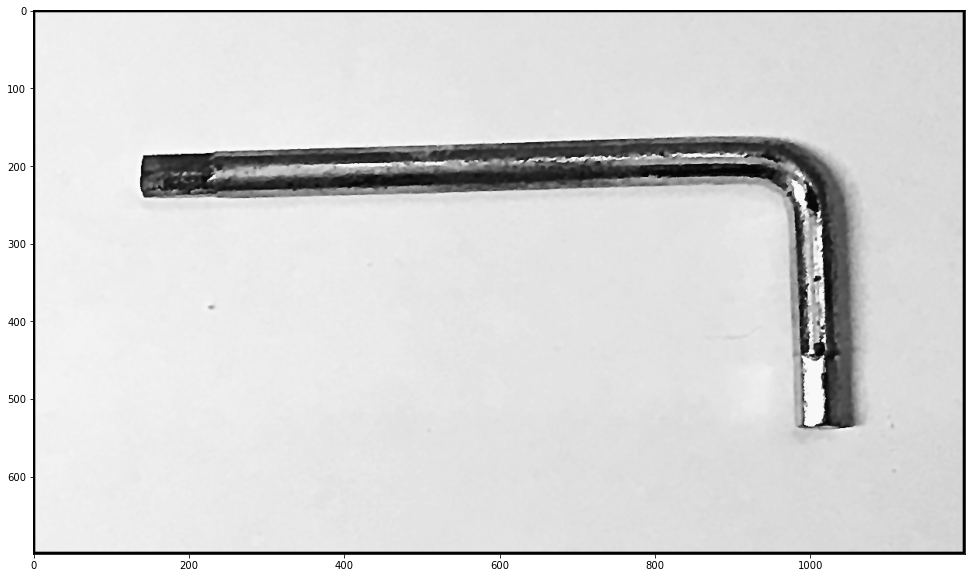

In [162]:
output = pr1.original.copy()
from scipy.spatial import distance as dist

#pr1.im#RETR_EXTERNAL only retrive outer contours
(cnts, _) = cv2.findContours(pr1.image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


def filter_biggest_contour_areas(cnts, num):
    '''
    get num biggest areas from cnts
    '''
    cnt_areas = [cv2.contourArea(cnt) for cnt in cnts]
    cnt_areas.sort()
    cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) >= cnt_areas[-num]]
    return cnts

num_objects_on_image = 1
cnts = filter_biggest_contour_areas(cnts, num_objects_on_image)

for contour in cnts:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(output,[box],0,(0,0,0),4)
    
    (a, b, c, d) = box
    ab = dist.euclidean(a, b)
    bc = dist.euclidean(b, c)
    cd = dist.euclidean(c, d)
    da = dist.euclidean(d, a)

plt.figure(figsize=(20,10))
plt.imshow(output, cmap = "gray")

In [133]:
cv.medianBlur?

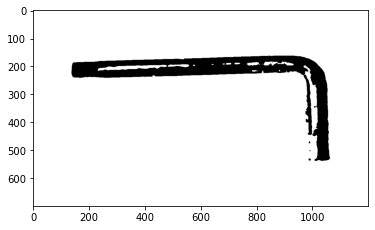

In [163]:
cancop = pr1.image.copy()
plt.imshow(cancop, cmap="gray")

In [164]:
# Find contours
contours, a = cv.findContours(cancop, 1, 2)
cnt = contours[0]
M = cv.moments(cnt)

In [165]:
area = cv.contourArea(cnt)
area

61.0

In [166]:
hull = cv.convexHull(cnt)

In [167]:
hull

array([[[995, 535]],

       [[992, 538]],

       [[990, 538]],

       [[988, 537]],

       [[987, 536]],

       [[986, 534]],

       [[986, 532]],

       [[989, 529]],

       [[992, 529]],

       [[995, 532]]], dtype=int32)

In [170]:
rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(cancop,[box],0,(0,0,0),2)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

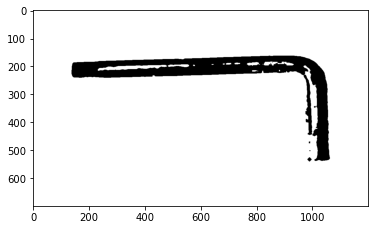

In [172]:
plt.imshow(cancop, cmap = "gray")

In [179]:
contours

[array([[[   0,    0]],
 
        [[   0,  699]],
 
        [[1199,  699]],
 
        [[1199,    0]]], dtype=int32),
 array([[[989, 529]],
 
        [[992, 529]],
 
        [[995, 532]],
 
        [[995, 535]],
 
        [[992, 538]],
 
        [[990, 538]],
 
        [[989, 537]],
 
        [[988, 537]],
 
        [[987, 536]],
 
        [[987, 535]],
 
        [[986, 534]],
 
        [[986, 532]]], dtype=int32),
 array([[[989, 501]],
 
        [[990, 500]],
 
        [[993, 500]],
 
        [[994, 501]],
 
        [[994, 503]],
 
        [[993, 504]],
 
        [[990, 504]],
 
        [[989, 503]]], dtype=int32),
 array([[[990, 469]],
 
        [[991, 468]],
 
        [[992, 468]],
 
        [[993, 469]],
 
        [[993, 475]],
 
        [[992, 476]],
 
        [[988, 476]],
 
        [[987, 475]],
 
        [[987, 470]],
 
        [[988, 469]]], dtype=int32),
 array([[[1009,  342]],
 
        [[1010,  341]],
 
        [[1013,  344]],
 
        [[1013,  346]],
 
        [[1010,  349

In [128]:
def contours(image, draw=True):
    # Find contours
    img = image.copy()
    contours, hierarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    if draw:
        cv.drawContours(img, contours, -1, (50,255,50), 3)
    return (img, contours) 

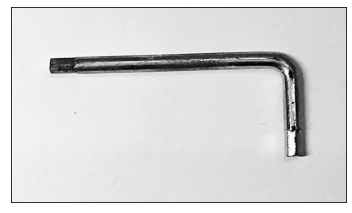

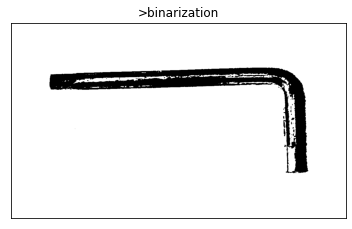

NameError: name 'get_contours' is not defined

In [129]:
pr1 = cvProc(imgProbe.copy());
pr1.binarize(threshold = 150)
im11 = pr1.image.copy()
im22, cont = get_contours(im11, min_area=10, max_area=None)

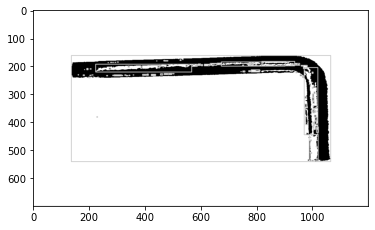

In [130]:
import cv2

im = pr1.image.copy() #cv2.imread('c:/data/ph.jpg')
#cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
gray=im #cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
cv2.threshold(gray, 150, 255, 1)
plt.imshow(gray)
contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
idx =0 
for cnt in contours:
    idx += 1
    x,y,w,h = cv2.boundingRect(cnt)
    roi=im[y:y+h,x:x+w]
    cv2.imwrite(str(idx) + '.jpg', roi)
    cv2.rectangle(im,(x,y),(x+w,y+h),(200,0,0),2)
plt.imshow(im, cmap = "gray") #cv2.imshow('img',im)

In [73]:
cnt

array([[[   0,    0]],

       [[   0,  699]],

       [[1199,  699]],

       [[1199,    0]]], dtype=int32)

In [ ]:
#image, contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE,
#                cv2.CHAIN_APPROX_SIMPLE)

# with each contour, draw boundingRect in green
# a minAreaRect in red and
# a minEnclosingCircle in blue
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a green rectangle to visualize the bounding rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # get the min area rect
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    box = np.int0(box)
    # draw a red 'nghien' rectangle
    cv2.drawContours(img, [box], 0, (0, 0, 255))

    # finally, get the min enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(c)
    # convert all values to int
    center = (int(x), int(y))
    radius = int(radius)
    # and draw the circle in blue
    img = cv2.circle(img, center, radius, (255, 0, 0), 2)

print(len(contours))
cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imshow("contours", img)

cv2.imshow("contours", img)

In [78]:
# Approximate contours to polygons + get bounding rects and circles
contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
centers = [None]*len(contours)
radius = [None]*len(contours)
for i, c in enumerate(contours):
    contours_poly[i] = cv.approxPolyDP(c, 3, True)
    boundRect[i] = cv.boundingRect(contours_poly[i])
    centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])

In [82]:
boundRect

[(1014, 530, 1, 1),
 (995, 509, 1, 1),
 (1014, 487, 1, 1),
 (1020, 464, 1, 1),
 (994, 463, 2, 4),
 (992, 454, 1, 1),
 (989, 444, 32, 92),
 (994, 441, 1, 1),
 (1004, 425, 1, 1),
 (1003, 418, 1, 1),
 (1015, 417, 7, 20),
 (1004, 411, 1, 1),
 (1003, 410, 1, 1),
 (1003, 403, 1, 1),
 (1002, 401, 4, 2),
 (1008, 396, 6, 12),
 (1010, 383, 7, 12),
 (976, 380, 8, 29),
 (228, 381, 1, 1),
 (1007, 376, 7, 5),
 (995, 371, 1, 1),
 (1010, 363, 1, 1),
 (1001, 361, 1, 1),
 (1010, 360, 1, 1),
 (996, 359, 1, 1),
 (1004, 355, 2, 12),
 (977, 353, 1, 1),
 (1009, 350, 1, 1),
 (1003, 341, 13, 9),
 (975, 335, 5, 12),
 (1004, 326, 1, 7),
 (1003, 311, 1, 13),
 (976, 308, 1, 7),
 (1003, 299, 1, 12),
 (1007, 292, 2, 6),
 (1000, 276, 1, 1),
 (202, 240, 1, 1),
 (199, 240, 1, 1),
 (232, 238, 1, 1),
 (965, 237, 4, 3),
 (320, 234, 1, 1),
 (333, 233, 6, 1),
 (263, 233, 4, 2),
 (343, 232, 1, 1),
 (320, 232, 1, 1),
 (285, 232, 4, 2),
 (203, 232, 4, 2),
 (956, 232, 7, 2),
 (358, 231, 1, 1),
 (328, 231, 5, 2),
 (290, 232, 27,

## probe image 2

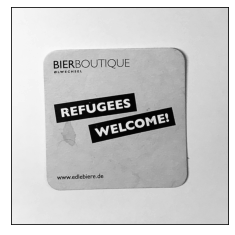

TypeError: median() got an unexpected keyword argument 'FWHM'

In [302]:
pr2 = cvProc(imgProbe2.copy())
pr2.median(FWHM = 15)
pr2.binarize(threshold = 120)
pr2.auto_canny()
pr2.houghlines(minline = 550, maxgap = 25)

In [109]:
h,b= pr2.image.shape

In [102]:
pr2.lines

array([[[149, 619, 740, 526]],

       [[382, 631, 997, 489]],

       [[148, 619, 742, 525]]], dtype=int32)

## Winkel berechnen

$\alpha = \arctan(\frac{y2-y1}{x2-x1})$

In [110]:
# delete overlapping lines
# choose the smaller of the lines, if overlapping

def angle(inpList):
    alpha = []
    for element in inpList:
        element = element[0] # get rid of brackets
        # convert
        y2 = h - element[3]
        y1 = h - element[1]
        x2 = element[2]
        x1 = element[0]
        alpha.append(np.rad2deg(np.arctan(
            ( y2-y1 ) / (x2-x1 ))))
    return alpha

def smashLines(inpList, angle, tolerance = 3):
    # generate a list of duplicate angles
    for 
    
    for i,a in zip(inpList, angle):
        


In [111]:
angle(pr2.lines)

[8.942753948409715, 13.001420708226178, 8.99243843274894]

## try ORB

In [67]:
# Initiate ORB detector
orb = cv.ORB_create()


In [68]:
orbim = imgProbe2.copy()
# find the keypoints with ORB
kp = orb.detect(orbim,None)


In [69]:
# compute the descriptors with ORB
kp, des = orb.compute(orbim, kp)

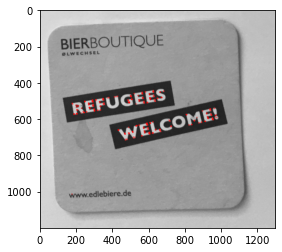

(<matplotlib.image.AxesImage at 0x26235f2df98>, None)

In [72]:
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(orbim, kp, None, color=(255,0,0), flags=0)
plt.imshow(img2), plt.show()

# process reference image

## gaussian filter

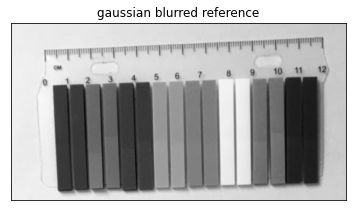

In [103]:
blur = imgRef.copy()
blur = cv.GaussianBlur(blur, (9, 9), 0)
f = plt.imshow(blur, cmap = 'gray'),plt.title("gaussian blurred reference"), plt.xticks([]), plt.yticks([]), plt.show()

## histogram stretching'

## binarize

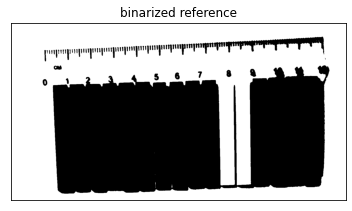

In [107]:
threshold = 170
bimg = blur.copy()
bimg[bimg < threshold] = 0
bimg[bimg>= threshold] = 255
f = plt.imshow(bimg, cmap = 'gray'),plt.title("binarized reference"), plt.xticks([]), plt.yticks([]), plt.show()

## edges

I use Canny edge detector, with an automatic evaluation of the thresholds, retrieved from: https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

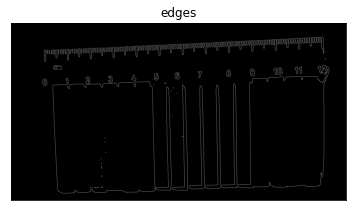

In [94]:
import argparse
import glob
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv.Canny(image, lower, upper)

    # return the edged image
    return edged

edges = auto_canny(bimg)

f = plt.imshow(edges, cmap = 'gray'),plt.title("edges"), plt.xticks([]), plt.yticks([]), plt.show()

## dilate --> erode

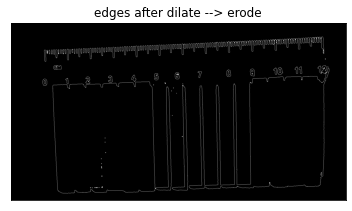

In [95]:
# dilate --> erode
edges = cv.dilate(edges, None, iterations=1)
edges = cv.erode(edges, None, iterations=1)
f = plt.imshow(edges, cmap = 'gray'),plt.title("edges after dilate --> erode"), plt.xticks([]), plt.yticks([]), plt.show()

extracted 18 lines!


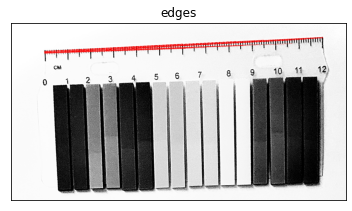

In [97]:
img2 = imgRef.copy()
lines = cv.HoughLinesP(edges,  1, np.pi/180, 20, maxLineGap=25, minLineLength = 700) # threshold (last parameter) may be evaluated
print("extracted " + str(len(lines)) + " lines!")

img2 = cv.cvtColor(img2,cv.COLOR_GRAY2RGB)
lineSizes = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        lineSizes.append(np.sqrt((x2-x1)**2 + (y2-y1)**2)) # write the line distances in px
        cv.line(img2, (x1, y1), (x2, y2), color = (255,0,0), thickness = 1)
        
f = plt.imshow(img2, cmap = 'gray'),plt.title("edges"), plt.xticks([]), plt.yticks([]), plt.show()

### how long is the longest edge?

Text(0.1, 1401.7756764903577, 'longest line')

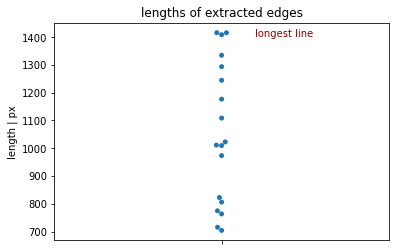

In [98]:
sns.swarmplot(lineSizes, orient="vertical")
plt.ylabel("length | px")
plt.title("lengths of extracted edges")
plt.text(x=.1, y = np.max(lineSizes)*.99, s = "longest line", color = "darkred" )

In [99]:
# externally measure the reference line
refLineMM = 120 # left out the round-ish edges

mmPpx = refLineMM / np.max(lineSizes)
print("Longest line in image is " + str(np.max(lineSizes)) + " px")
print("Each pixel is around " + str(np.round(mmPpx,2)) + " mm.")

Longest line in image is 1415.935026757937 px
Each pixel is around 0.08 mm.


In [17]:
1449/80

18.1125

#### probe images

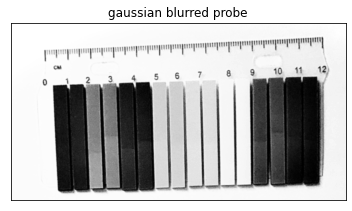

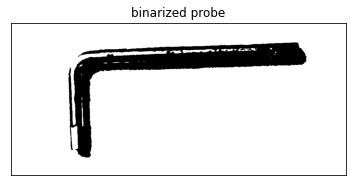

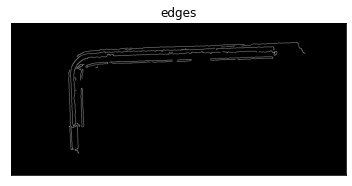

extracted 13 lines!


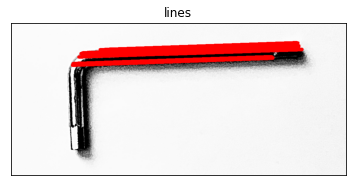

In [90]:
bimg = imgProbe.copy()
bimg = cv.GaussianBlur(bimg, (9, 9), 0)
f = plt.imshow(blur, cmap = 'gray'),plt.title("gaussian blurred probe"), plt.xticks([]), plt.yticks([]), plt.show()

threshold = 150
bbimg = bimg.copy()
bbimg[bbimg < threshold] = 0
bbimg[bbimg>= threshold] = 255
f = plt.imshow(bbimg, cmap = 'gray'),plt.title("binarized probe"), plt.xticks([]), plt.yticks([]), plt.show()

edges = auto_canny(bimg)
f = plt.imshow(edges, cmap = 'gray'),plt.title("edges"), plt.xticks([]), plt.yticks([]), plt.show()

# dilate --> erode
edges = cv.dilate(edges, None, iterations=1)
edges = cv.erode(edges, None, iterations=1)

imgProbe2 = imgProbe.copy() #/ 10
lines = cv.HoughLinesP(edges,  1, np.pi/180, 20, maxLineGap=100, minLineLength = 400) # threshold (last parameter) may be evaluated
print("extracted " + str(len(lines)) + " lines!")

imgProbe2 = cv.cvtColor(imgProbe2,cv.COLOR_GRAY2RGB)
lineSizes = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        lineSizes.append(np.sqrt((x2-x1)**2 + (y2-y1)**2)) # write the line distances in px
        cv.line(imgProbe2, (x1, y1), (x2, y2), color = (255, 0, 0), thickness = 10)
        
f = plt.imshow(imgProbe2, cmap = 'gray'),plt.title("lines"), plt.xticks([]), plt.yticks([]), plt.show()

### how long is the longest edge?

Text(0.5, 1.0, 'lengths of edges')

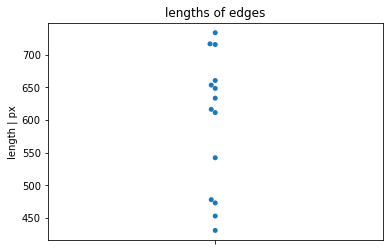

In [84]:
sns.swarmplot(lineSizes, orient="vertical")
plt.ylabel("length | px")
plt.title("lengths of edges")

In [85]:
def outputLine(inpList):
    """
    takes a list of pixel distances as input
    """
    out = [i*mmPpx for i in inpList]
    return out
    
lineSizesMM = outputLine(lineSizes)

Text(0.5, 1.0, 'lengths of edges')

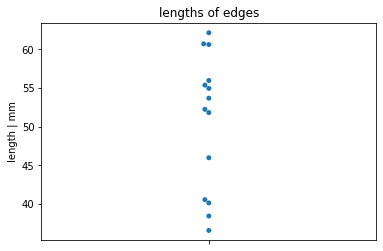

In [86]:
sns.swarmplot(lineSizesMM, orient="vertical")
plt.ylabel("length | mm")
plt.title("lengths of edges")